In [2]:
# Parametros generales

import sionna
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sionna.phy.config.seed = 2000 # semilla para reproducibilidad
N = 256 # longitud del código
K = 128 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 1 # bits por símbolo (BPSK)
list_size = 8 # tamaño de lista para SCL
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo
batch_size = 1000 # tamaño de lote para simulación
num_iter = 2 # las pruebas por bit-canal seran batch_size * num_iter
ebno_db = 10.0 # Eb/N0 en dB
list_size = 8 # tamaño de lista para SCL

2026-01-10 22:05:44.420121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 22:05:44.430202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768100744.440858   90865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768100744.444334   90865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768100744.453748   90865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

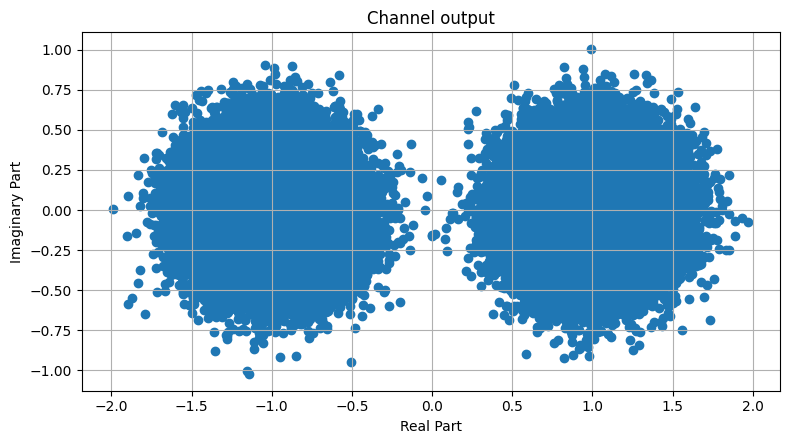

In [3]:
# Simulacion AWGN sin codigo de canal

datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb) # para mas bitsxsimb usar "qam"
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)

b = datos([batch_size, K])
x = mapeador(b)

no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=1.0)
awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn = tf.complex(awgn_real, awgn_imag)
y = x + awgn
llr = demapeador(y, no)

plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

In [4]:
# Verificacion de AWGN sin codigo de canal

num_samples = 8

print(tf.shape(b))
print(f"First 2x{num_samples} transmitted bits: {b[:2,:num_samples]}")
print(tf.shape(x))
print(f"First 2x{num_samples} transmitted x: {x[:2,:num_samples]}")
print(tf.shape(awgn))
print(f"First 2x{num_samples} generated noise: {awgn[:2,:num_samples]}")
print(tf.shape(y))
print(f"First 2x{num_samples} received y: {y[:2,:num_samples]}")
print(tf.shape(llr))
print(f"First 2x{num_samples} evaluated llr: {llr[:2,:num_samples]}")


tf.Tensor([1000  128], shape=(2,), dtype=int32)
First 2x8 transmitted bits: [[0. 0. 0. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1.]]
tf.Tensor([1000  128], shape=(2,), dtype=int32)
First 2x8 transmitted x: [[ 1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j]]
tf.Tensor([1000  128], shape=(2,), dtype=int32)
First 2x8 generated noise: [[-0.06433176-0.204094j    0.5587494 +0.18965282j  0.11325563+0.4734706j
  -0.10742683-0.02818957j -0.12026983-0.2101576j  -0.30551082+0.02159118j
  -0.17181756-0.32820517j -0.02071206-0.15230137j]
 [ 0.2920878 -0.3638691j   0.24571902+0.11432272j  0.17801422+0.44824615j
   0.03668774-0.1581563j   0.28370008-0.32011878j  0.2724627 -0.04811211j
   0.18338591-0.37357894j  0.25523484+0.0364279j ]]
tf.Tensor([1000  128], shape=(2,), dtype=int32)
First 2x8 received y: [[ 0.93566823-0.204094j    1.5587494 +0.18965282j  1.1132556 +0.4734706j
  -1.1074269 -0.02818957j  0.87973017-0.21015

In [5]:
# Simulacion Monte Carlo AWGN para codigo polar con SCL

no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
BER_bits = np.zeros(N)
i = 0 # bit-canal a analizar

bits_congelados = np.array([j for j in range(N) if j != i]) # se congela todo menos el bit i
codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=list_size)
errores_totales = 0
bits_totales = 0
# Se generan simulaciones sobre el canal AWGN
for b in range(num_iter):
    # Bloques de transmision
    bits = datos([batch_size, 1]) # solo 1 bit de datos por bit-canal
    bits_codif = codificador(bits)
    x = mapeador(bits_codif)

    # Canal AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag)
    y = x + awgn

    # Demapeo LLR
    llr = demapeador(y, no)
    bits_decodif = decodificador(llr)

    # Cálculo de errores
    err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
    errores_totales += int(err.numpy())
    bits_totales += batch_size  # porque bits es [bs,1] → 1 bit por muestra

BER_bits[i] = errores_totales / bits_totales

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


In [8]:
print(err)
tf.math.count_nonzero(tf.not_equal(bits, bits_decodif))

tf.Tensor(3, shape=(), dtype=int32)


<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [ ]:
# Verificacion de AWGN con codigo de canal

num_samples = 8

print(tf.shape(b))
print(f"First 2x{num_samples} transmitted bits: {b[:2,:num_samples]}")
print(tf.shape(x))
print(f"First 2x{num_samples} transmitted x: {x[:2,:num_samples]}")
print(tf.shape(awgn))
print(f"First 2x{num_samples} generated noise: {awgn[:2,:num_samples]}")
print(tf.shape(y))
print(f"First 2x{num_samples} received y: {y[:2,:num_samples]}")
print(tf.shape(llr))
print(f"First 2x{num_samples} evaluated llr: {llr[:2,:num_samples]}")